In [3]:
! pip install --upgrade numpy


  Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


  You can safely remove it manually.
  You can safely remove it manually.


In [5]:
! pip uninstall matplotlib
! pip install matplotlib


^C


In [1]:
! pip install pandas bs4


  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)


In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [6]:
import PyPDF2 

In [31]:
# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_file):
    with open(pdf_file, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

# Function to split text into sentences using spaCy
def split_text_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

# Function to load multiple PDFs into a single DataFrame
def load_multiple_pdfs_into_dataframe(pdf_files):
    all_sentences = []
    
    for pdf_file in pdf_files:
        text = extract_text_from_pdf(pdf_file)
        sentences = split_text_into_sentences(text)
        all_sentences.extend(sentences)  # Add sentences from each PDF to the list
    
    # Create a DataFrame with the combined sentences
    df = pd.DataFrame(all_sentences, columns=['Sentence'])
    return df

In [32]:
# Example usage with multiple PDF files
pdf_files = [
    r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\41392_2020_Article_448_(1).pdf',
    r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\djad159_(7).pdf',
    r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\jco-40-1755_(5).pdf',
    r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\ONCO-26-e2130_(3).pdf',
    r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\s12964-023-01332-9_(2).pdf'
]

In [33]:
# Example usage:
#pdf_file_path = r'C:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\input_files\pdf_files\41392_2020_Article_448_(1).pdf'
df = load_multiple_pdfs_into_dataframe(pdf_files)

# Display the DataFrame
print(df)

                                                                                                                                                                                                     Sentence
0     ARTICLE OPEN\nPersonalized neoantigen pulsed dendritic cell vaccine for\nadvanced lung cancer\nZhenyu Ding1,2, Qing Li1,2, Rui Zhang1, Li Xie1, Yang Shu1, Song Gao3, Peipei Wang1,2, Xiaoqing Su1, ...
1                                                      Heng Xu1and Li Yang1\nNeoantigens are considered to be ultimate target of tumor immunotherapy due to their high tumor speci ﬁcity and\nimmunogenicity.
2                                                   Dendritic cell (DCs) vaccines based on neoantigens have exciting effects in treatment of some malignant tumors\nand are a promising therapeutic modality.
3                                                                                                                 Lung cancer is a lethal disease with the highest morbidity and

In [34]:
df.sample(4)

,Sentence
347,"After washing with\npermeabilization buffer and ﬁxation (BD Biosciences), cells were\nanalyzed using a BD FACSAria II ﬂow cytometer."
1873,27.
37,"Additionally, RNAsequencing (RNA-seq) was also performed for each tumor sample,not only con ﬁrming the expression status of the mutations but\nalso detecting possible fusion-based neoantigens."
170,Clinical and immune responses to personalized Neo-DCVac in patient 1 with metastatic lung adenocarcinoma.


In [35]:
df.shape 

(2146, 1)

In [36]:
def get_entities(sent):
    # Initialize variables to store entities
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # Dependency tag of previous token in the sentence
    prv_tok_text = ""  # Previous token in the sentence

    prefix = ""
    modifier = ""

    # Loop through the tokens generated by spaCy's NLP model
    for tok in nlp(sent):
        # Skip punctuation tokens
        if tok.dep_ != "punct":
            # Check if the token is part of a compound word
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # Check if the token is a modifier (like an adjective)
            if tok.dep_.endswith("mod"):
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            # Check if the token is a subject
            if "subj" in tok.dep_:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            # Check if the token is an object
            if "obj" in tok.dep_:
                ent2 = modifier + " " + prefix + " " + tok.text

        # Update previous token details
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text

    # Return the extracted subject and object entities
    return [ent1.strip(), ent2.strip()]

# Example usage
print(get_entities("the film had 200 patents"))


['film', '200  patents']


In [37]:
get_entities("the film had 200 patents")


['film', '200  patents']

In [38]:
entity_pairs = []

for i in tqdm(df["Sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 2146/2146 [00:15<00:00, 140.43it/s]


In [39]:
entity_pairs[10:20]


[['total', 'doses vaccine person'],
 ['based  neoantigens', 'patient'],
 ['adverse  events', 'toxic  effects'],
 ['overall  survival', ''],
 ['study', 'therapeutic lung cancer treatment'],
 ['malignant  that', 'human healthand life'],
 ['advanced  who', 'limited frontline therapeuticoptions'],
 ['main  goal', 'thus palliate life'],
 ['low toxicity therapy methods', ''],
 ['that cancer harness', 'past speci decades']]

In [40]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    # Define the pattern 
    pattern = [{'DEP': 'ROOT'}, 
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},  
               {'POS': 'ADJ', 'OP': "?"}] 

    # Add the pattern to the matcher
    matcher.add("matching_1", [pattern])  # Updated syntax for matcher.add()

    # Find matches in the sentence
    matches = matcher(doc)
    if matches:
        # Get the last match (span)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return span.text
    else:
        return None  # If no match is found, return None

# Example usage
print(get_relation("John completed the task"))


completed


In [41]:
get_relation("John completed the task")


'completed'

In [42]:
relations = [get_relation(i) for i in tqdm(df['Sentence'])]


100%|██████████| 2146/2146 [00:15<00:00, 137.46it/s]


In [43]:
pd.Series(relations).value_counts()[:50]


was                 52
is                  47
were                37
Cancer              21
used                19
had                 17
are                 16
Med                 15
[                   14
Oncol               13
Res                 12
pulsed dendritic    10
showed              10
reported            10
Nat                  9
M                    9
to                   9
received             9
performed            9
©                    8
found                8
Nature               8
E                    8
conducted            8
be                   8
S                    8
Immunol              7
Biol                 7
has                  7
Sci                  7
Communication        7
have                 7
al                   7
Inst                 6
Y                    6
12                   6
demonstrated         6
Oncologist           6
contributed          6
assessed             6
A                    6
Clin                 6
developed            5
13         

In [44]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [60]:
kg_df.sample(3)

,source,target,edge
618,stepped wedge details,which,reported
215,ﬁltering criteria,methods section,described in
951,,Behavioral Sciences,Analysis for


In [61]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

c:\Users\HP\Visual Studio Code Project\knowledge Graph from spacy\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


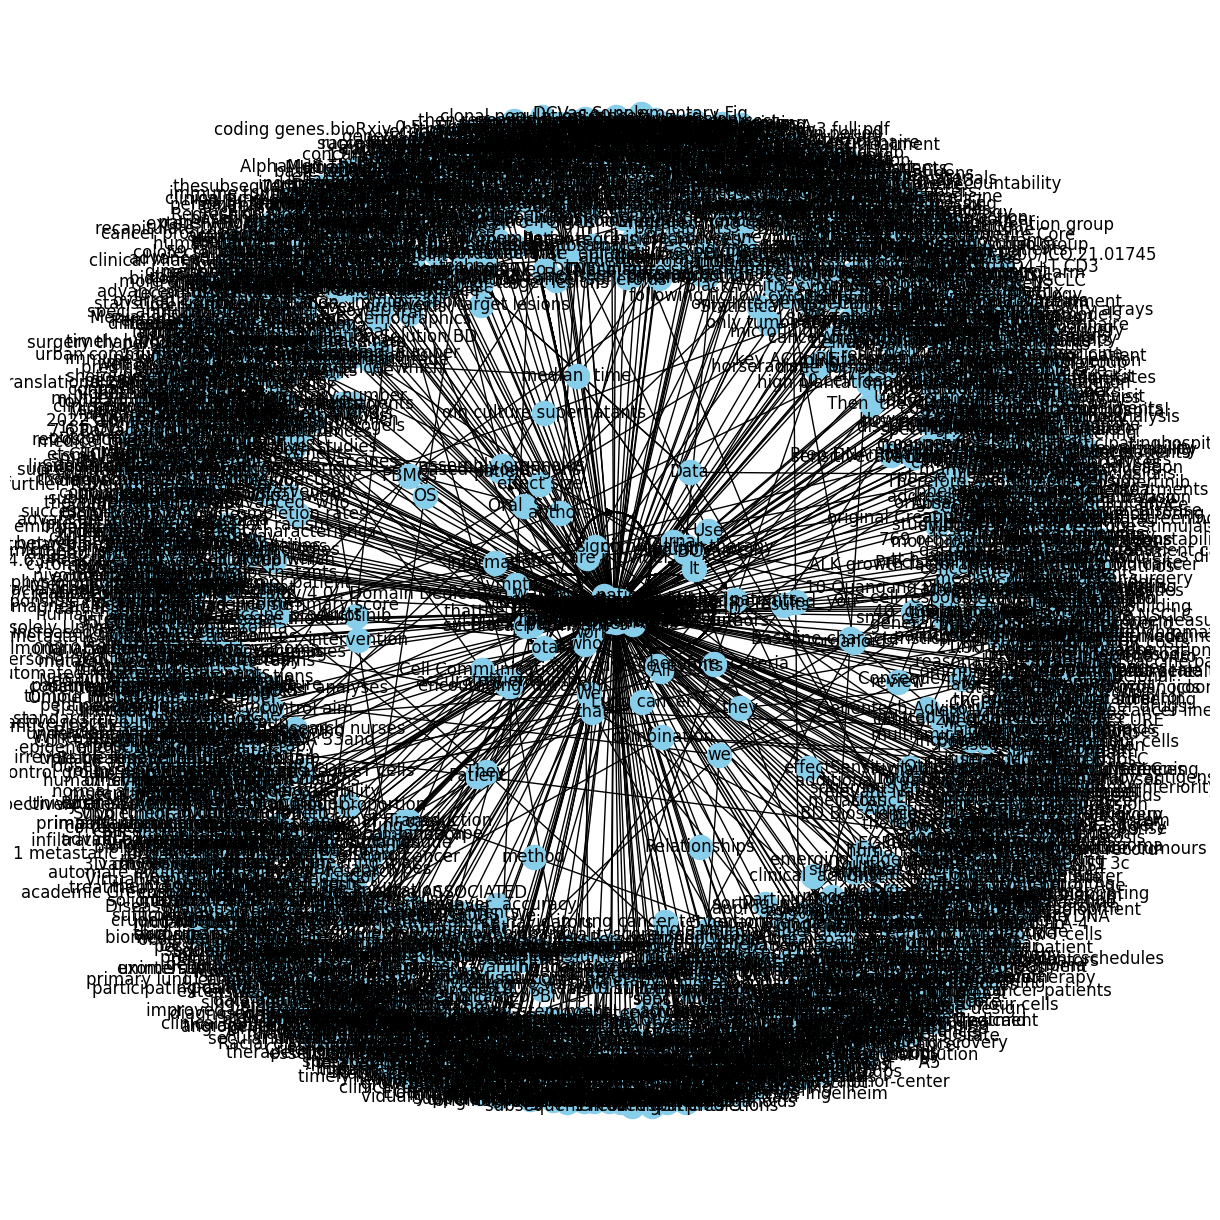

In [62]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

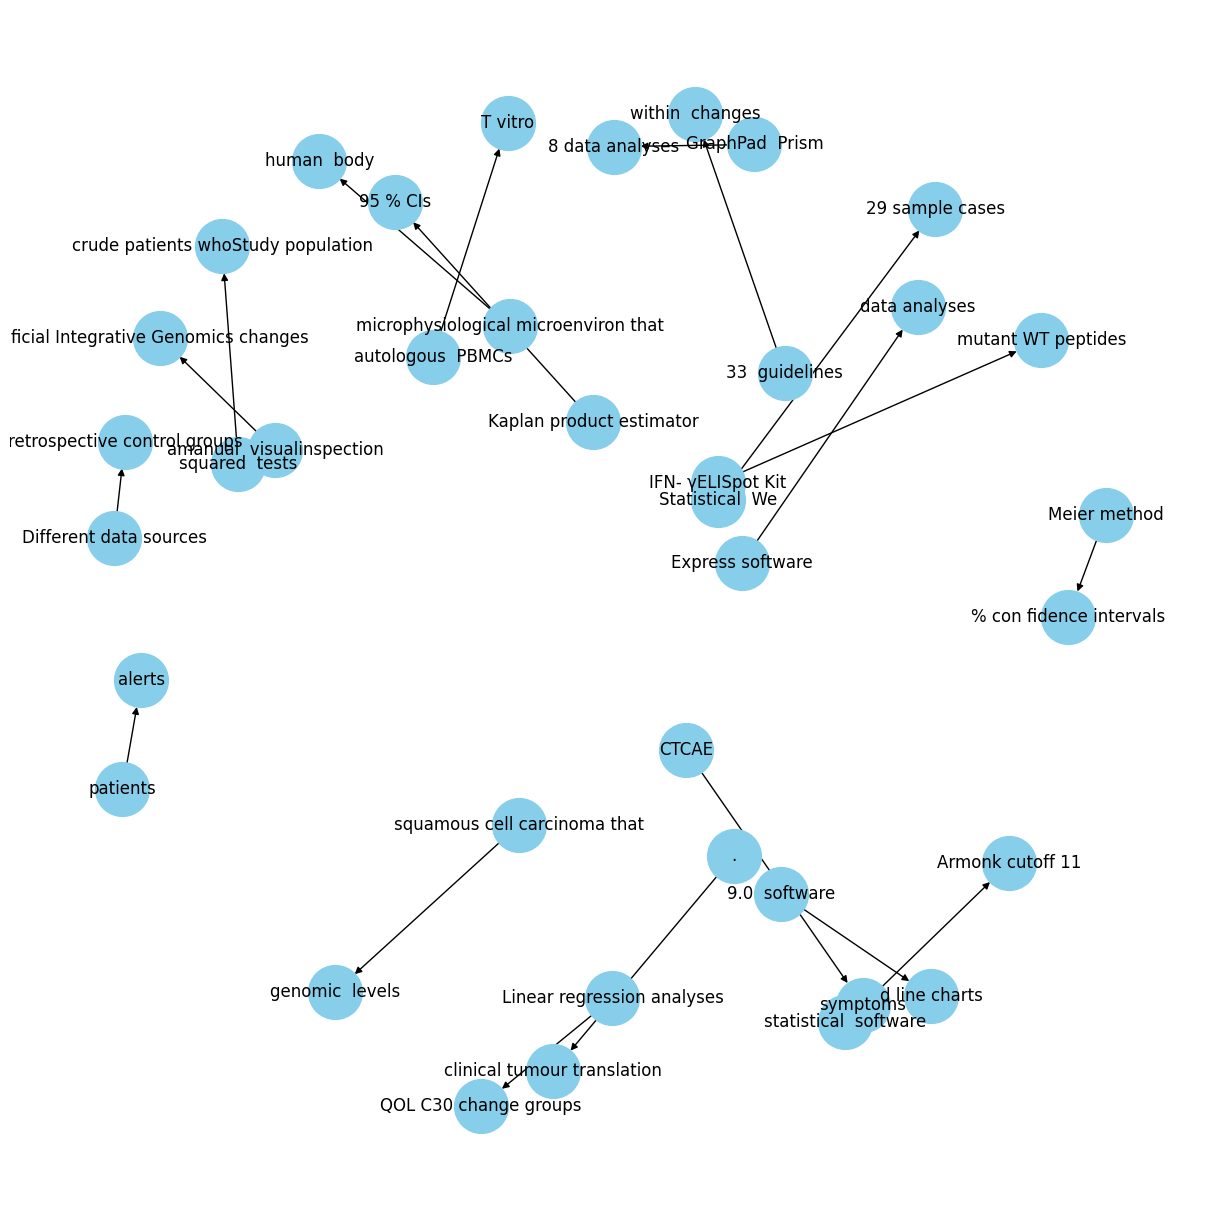

In [66]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [67]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt

# Assuming your entity_pairs and relations are already extracted

# Create the DataFrame from source, target, and relations
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

# Create a directed graph using networkx
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

# Initialize PyVis Network
net = Network(notebook=True, directed=True)

# Load nodes and edges into PyVis Network
for node in G.nodes:
    net.add_node(node, label=node)

for edge in G.edges(data=True):
    src = edge[0]
    dst = edge[1]
    label = edge[2].get('edge', '')  # Get the relation (edge label)
    net.add_edge(src, dst, title=label)

# Customize the appearance (optional)
net.repulsion(node_distance=200, spring_length=300)

# Show the graph in a browser (or export as HTML)
net.show("graph_visualization.html")


graph_visualization.html
